In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
from tqdm.notebook import tqdm
from Eearly_stop import *
from sklearn.metrics import roc_auc_score, accuracy_score
import sys
import pandas as pd
import argparse
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import math
from torch.utils.data import Dataset, DataLoader
from src_py.cpmix_utils import preprocess_data
from src_py.rhorho import RhoRhoEvent
from src_py.a1a1 import A1A1Event
from src_py.a1rho import A1RhoEvent
from src_py.data_utils import read_np, EventDatasets
from src_py.process_background import convert_bkgd_raw
import train_rhorho, train_a1rho, train_a1a1
from src_py.metrics_utils import calculate_deltas_unsigned, calculate_deltas_signed

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print('Using {} device'.format(device))

Using cpu device


In [3]:
decaymodes = ['rhorho', 'a1rho', 'a1a1']
types = {"nn_rhorho": train_rhorho.start,"nn_a1rho": train_a1rho.start,"nn_a1a1": train_a1a1.start}
parser = argparse.ArgumentParser(description='Train classifier')

parser.add_argument("--num_classes", dest="NUM_CLASSES", type=int, default=11)
parser.add_argument("-l", "--layers", dest="LAYERS", type=int, help = "number of NN layers", default=6)
parser.add_argument("-s", "--size", dest="SIZE", type=int, help="NN size", default=100)
parser.add_argument("-lambda", "--lambda", type=float, dest="LAMBDA", help="value of lambda parameter", default=0.0)
parser.add_argument("-m", "--method", dest="METHOD", choices=["A", "B", "C"], default="A")
parser.add_argument("-o", "--optimizer", dest="OPT", 
    choices=["GradientDescentOptimizer", "AdadeltaOptimizer", "AdagradOptimizer",
         "ProximalAdagradOptimizer", "AdamOptimizer", "FtrlOptimizer",
         "ProximalGradientDescentOptimizer", "RMSPropOptimizer"], default="AdamOptimizer")
parser.add_argument("-d", "--dropout", dest="DROPOUT", type=float, default=0.0)
parser.add_argument("-e", "--epochs", dest="EPOCHS", type=int, default=3)
# parser.add_argument("-f", "--features", dest="FEAT", help="Features", default="Variant-All")
# #         choices= ["Variant-All", "Variant-1.0", "Variant-1.1", "Variant-2.0", "Variant-2.1",
# #                   "Variant-2.2", "Variant-3.0", "Variant-3.1", "Variant-4.0", "Variant-4.1"])

########### Change this to according dir to download data #######################
parser.add_argument("-i", "--input", dest="IN", default='/home/anderson/higgs_data/rhorho')

parser.add_argument("--miniset", dest="MINISET", type=lambda s: s.lower() in ['true', 't', 'yes', '1'], default=False)
parser.add_argument("--z_noise_fraction", dest="Z_NOISE_FRACTION", type=float, default=0.0)
parser.add_argument("--z_fraction", dest="Z_FRACTION", type=float, default=0.0)

parser.add_argument("--delt_classes", dest="DELT_CLASSES", type=int, default=0,
                    help='Maximal distance between predicted and valid class for event being considered as correctly classified')

parser.add_argument("--unweighted", dest="UNWEIGHTED", type=lambda s: s.lower() in ['true', 't', 'yes', '1'], default=False)
parser.add_argument("--reuse_weights", dest="REUSE_WEIGHTS", type=bool, default=False)
parser.add_argument("--restrict_most_probable_angle", dest="RESTRICT_MOST_PROBABLE_ANGLE", type=bool, default=False)
parser.add_argument("--force_download", dest="FORCE_DOWNLOAD", type=bool, default=False)
parser.add_argument("--normalize_weights", dest="NORMALIZE_WEIGHTS", type=bool, default=False)


parser.add_argument("--beta",  type=float, dest="BETA", help="value of beta parameter for polynomial smearing", default=0.0)
parser.add_argument("--pol_b", type=float, dest="pol_b", help="value of b parameter for polynomial smearing", default=0.0)
parser.add_argument("--pol_c", type=float, dest="pol_c", help="value of c parameter for polynomial smearing", default=0.0)

parser.add_argument("--w1", dest="W1")
parser.add_argument("--w2", dest="W2")
parser.add_argument("--f", dest="FEAT", default="Variant-All")
parser.add_argument("--plot_features", dest="PLOT_FEATURES", choices=["NO", "FILTER", "NO-FILTER"], default="NO")
parser.add_argument("--training_method", dest="TRAINING_METHOD", choices=["soft_weights", "soft_c012s",  "soft_argmaxs", "regr_c012s", "regr_weights", "regr_argmaxs"], default="soft_weights")
parser.add_argument("--hits_c012s", dest="HITS_C012s", choices=["hits_c0s", "hits_c1s",  "hits_c2s"], default="hits_c0s")

######Change this to according type (rhorho, a1rho, a1a1)#######################
parser.add_argument("-t", "--type", dest="TYPE", choices=types.keys(), default='nn_rhorho')

parser.add_argument("-r", "--reprocess", dest="REPRO", type=bool, default=False)
parser.add_argument("-bkgd", "--bkgdpath", dest="BKGDPATH", default='/home/anderson/Ztt_raw/pythia.Z_115_135.%s.1M.*.outTUPLE_labFrame')
parser.add_argument("--train_bkgd", dest="TRAINBKGD", default=False)

args, unknown = parser.parse_known_args()

### Loading signal samples

In [4]:
points=pickle.load(open(args.IN+'/events_PtEtaPhiE.pk','rb'))

### Training NN

In [5]:
batch_size=512

In [6]:
class MyDataset(Dataset):
    def __init__(self, rhorho_data_mc,rhorho_data_true,rhorho_labels_mc,rhorho_labels_true):
        self.rhorho_data_mc = torch.from_numpy(rhorho_data_mc).float().to(device)
        self.rhorho_data_true = torch.from_numpy(rhorho_data_true).float().to(device)
        
        self.rhorho_labels_mc =torch.from_numpy(rhorho_labels_mc).float().to(device)
        self.rhorho_labels_true =torch.from_numpy(rhorho_labels_true).float().to(device)
    def __getitem__(self, index):
        return self.rhorho_data_mc[index],self.rhorho_data_true[index],self.rhorho_labels_mc[index],self.rhorho_labels_true[index]
    def __len__(self):
        return min(len(self.rhorho_labels_mc),len(self.rhorho_labels_true))

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_features, num_classes, num_layers=1, size=100, lr=1e-3, drop_prob=0, inplace=False, 
                 tloss="regr_weights", activation='linear', input_noise=0.0, optimizer="AdamOptimizer"):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(num_features,size,bias=False)
        layers = []
        for i in range(num_layers):
            layers.extend([nn.Linear(size,size,bias=False),
                           nn.BatchNorm1d(size),
                           nn.ReLU(),
                           nn.Dropout(drop_prob, inplace)
                          ])
        self.linear_relu_stack = nn.Sequential(*layers)
        self.linear2 = nn.Linear(size,num_classes,bias=False)
        self.linear3 = nn.Linear(size,2,bias=False)
    def forward(self, x):
        x = self.linear1(x)
        x = self.linear_relu_stack(x)
        out = self.linear2(x)
        return out

In [8]:
particle_idx=0

mc_train_idx=np.random.choice(np.arange(points[particle_idx].train.x.shape[0]),int(points[particle_idx].train.x.shape[0]*0.5),replace=False)
true_train_idx=list(set(np.arange(points[particle_idx].train.x.shape[0]))-set(mc_train_idx))

mc_valid_idx=np.random.choice(np.arange(points[particle_idx].valid.x.shape[0]),int(points[particle_idx].valid.x.shape[0]*0.5),replace=False)
true_valid_idx=list(set(np.arange(points[particle_idx].valid.x.shape[0]))-set(mc_train_idx))

mc_test_idx=np.random.choice(np.arange(points[particle_idx].test.x.shape[0]),int(points[particle_idx].test.x.shape[0]*0.5),replace=False)
true_test_idx=list(set(np.arange(points[particle_idx].test.x.shape[0]))-set(mc_train_idx))

In [9]:
uncertainty=0.0

train_datasets = MyDataset(points[particle_idx].train.x[mc_train_idx], points[particle_idx].train.x[true_train_idx]+uncertainty*np.random.normal(0,1,size=points[particle_idx].train.x[true_train_idx].shape),
                          points[particle_idx].train.weights[mc_train_idx],points[particle_idx].train.weights[true_train_idx])
train_loader = DataLoader(dataset = train_datasets,batch_size = batch_size,shuffle = True)


valid_datasets = MyDataset(points[particle_idx].valid.x[mc_valid_idx], points[particle_idx].valid.x[true_valid_idx]+uncertainty*np.random.normal(0,1,size=points[particle_idx].valid.x[true_valid_idx].shape),
                          points[particle_idx].valid.weights[mc_valid_idx],points[particle_idx].valid.weights[true_valid_idx])
valid_loader = DataLoader(dataset = valid_datasets,batch_size = batch_size,shuffle = True)


test_datasets = MyDataset(points[particle_idx].test.x[mc_test_idx], points[particle_idx].test.x[true_test_idx]+uncertainty*np.random.normal(0,1,size=points[particle_idx].test.x[true_test_idx].shape),
                          points[particle_idx].test.weights[mc_test_idx],points[particle_idx].test.weights[true_test_idx])
test_loader = DataLoader(dataset = test_datasets,batch_size = batch_size,shuffle = True)

In [10]:
model = NeuralNetwork(num_features=points[particle_idx].train.x.shape[1], num_classes=args.NUM_CLASSES,num_layers=args.LAYERS,drop_prob=0).to(device)
opt_g = torch.optim.Adam(model.parameters(),lr=1e-3)
criterion = nn.CrossEntropyLoss()
early_stopping = EarlyStopping(patience=10, verbose=True,path='model/feature_ranking.pt')

In [12]:
epoch=200
training_loss=[]
validation_loss=[]

for i in range(epoch):
    # training step
    model.train()
    train_loss,train_acc,train_numbers = 0,0,0
    for batch_idx, (rhorho_s,rhorho_t,label_s,label_t) in enumerate(train_loader):
        opt_g.zero_grad()
        rhorho_s = rhorho_s[label_s.sum(axis=1)!=0]
        label_s = label_s[label_s.sum(axis=1)!=0]
        outputs = model(rhorho_s)
        if isinstance(criterion,nn.CrossEntropyLoss):
            loss=criterion(outputs,torch.argmax(label_s,axis=1))
        else:
            loss=criterion(outputs,label_s)
        loss.backward()
        opt_g.step()
        _, predictions = torch.max(outputs, 1)
        train_loss += loss.item()*len(rhorho_s)
        train_acc += (predictions==torch.argmax(label_s,axis=1)).sum().item()
        train_numbers += len(rhorho_s)
        print('\r training loss: %.3f \t acc: %.3f \t' %(train_loss/train_numbers,train_acc/train_numbers),end='')
    print()
    training_loss.append(train_loss/train_numbers)
    
    # validation step
    model.eval()
    valid_loss,valid_acc,valid_numbers = 0,0,0
    with torch.no_grad():
        for batch_idx, (rhorho_s,rhorho_t,label_s,label_t) in enumerate(valid_loader):
            rhorho_s = rhorho_s[label_s.sum(axis=1)!=0]
            label_s = label_s[label_s.sum(axis=1)!=0]
            outputs = model(rhorho_s)
            if isinstance(criterion,nn.CrossEntropyLoss):
                loss=criterion(outputs,torch.argmax(label_s,axis=1))
            else:
                loss=criterion(outputs,label_s)
            _, predictions = torch.max(outputs, 1)
            valid_loss += loss.item()*len(rhorho_s)
            valid_acc += (predictions==torch.argmax(label_s,axis=1)).sum().item()
            valid_numbers += len(rhorho_s)
            print('\r validation loss: %.3f \t acc: %.3f \t' %(valid_loss/valid_numbers,valid_acc/valid_numbers),end='')
    print()
    validation_loss.append(valid_loss/valid_numbers)

    # early stopping
    early_stopping(-valid_acc/valid_numbers,model)
    if early_stopping.early_stop:
        print("Early stopping")
        break
    print()

 training loss: 1.235 	 acc: 0.502 	
 validation loss: 1.083 	 acc: 0.561 	

Validation loss decreased (inf --> -0.561483).  Saving model ...
 training loss: 1.082 	 acc: 0.556 	
 validation loss: 0.960 	 acc: 0.606 	

Validation loss decreased (-0.561483 --> -0.606281).  Saving model ...
 training loss: 1.003 	 acc: 0.585 	
 validation loss: 0.900 	 acc: 0.627 	

Validation loss decreased (-0.606281 --> -0.626719).  Saving model ...
 training loss: 0.953 	 acc: 0.603 	
 validation loss: 0.855 	 acc: 0.645 	

Validation loss decreased (-0.626719 --> -0.644694).  Saving model ...
 training loss: 0.904 	 acc: 0.623 	
 validation loss: 0.798 	 acc: 0.671 	

Validation loss decreased (-0.644694 --> -0.670737).  Saving model ...
 training loss: 0.870 	 acc: 0.636 	
 validation loss: 0.731 	 acc: 0.704 	

Validation loss decreased (-0.670737 --> -0.704186).  Saving model ...
 training loss: 0.841 	 acc: 0.648 	
 validation loss: 0.744 	 acc: 0.690 	

EarlyStopping counter: 1 out of 10
 train

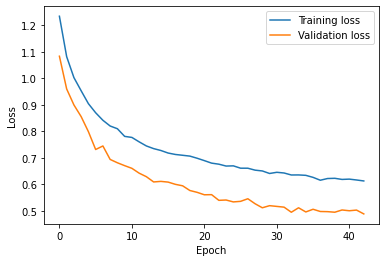

In [13]:
plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")

plt.legend()

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

### Feature ranking by permutation

In [14]:
test_acc,test_numbers,test_loss=0,0,0
model.eval()
with torch.no_grad():
    for batch_idx, (rhorho_s,rhorho_t,label_s,label_t) in enumerate(test_loader):
        rhorho_s = rhorho_s[label_s.sum(axis=1)!=0]
        label_s = label_s[label_s.sum(axis=1)!=0]
        outputs = model(rhorho_s)
        if isinstance(criterion,nn.CrossEntropyLoss):
            loss=criterion(outputs,torch.argmax(label_s,axis=1))
        else:
            loss=criterion(outputs,label_s)
        _, predictions = torch.max(outputs, 1)
        test_loss += loss.item()*len(rhorho_s)
        test_acc += (predictions==torch.argmax(label_s,axis=1)).sum().item()
        test_numbers += len(rhorho_s)
print()
print('\r test loss: %.3f \t acc: %.3f \t' %(test_loss/test_numbers,test_acc/test_numbers),end='')
loss_0 = test_loss/test_numbers


 test loss: 0.481 	 acc: 0.809 	

In [15]:
particle_name = ['n', 'pi-', 'pi0_1', 'an', 'pi+', 'pi0_2']
affiliated_name =['pT', 'eta', 'phi', 'E']
features_names=[ x+'_'+y for x in particle_name for y in affiliated_name]

In [16]:
data = []
for i in range(len(features_names)):
    data.append(0)

feat_imp = pd.DataFrame(np.zeros((1, 24)),columns=features_names)

In [23]:
for i,name in enumerate(features_names):
    loss_sum = 0
    model.eval()
    test_loss,test_acc,test_numbers = 0,0,0
    with torch.no_grad():
        for batch_idx, (rhorho_s,rhorho_t,label_s,label_t) in enumerate(test_loader):
            rhorho_s = rhorho_s[label_s.sum(axis=1)!=0]
            label_s = label_s[label_s.sum(axis=1)!=0]
            np.random.shuffle(rhorho_s[:,i]) # permute feature
            outputs = model(rhorho_s)
            if isinstance(criterion,nn.CrossEntropyLoss):
                loss=criterion(outputs,torch.argmax(label_s,axis=1))
            else:
                loss=criterion(outputs,label_s)
            _, predictions = torch.max(outputs, 1)
            test_loss += loss.item()*len(rhorho_s)
            test_acc += (predictions==torch.argmax(label_s,axis=1)).sum().item()
            test_numbers += len(rhorho_s)
    print(features_names[i] + ' test loss: %.3f \t acc: %.3f \t' %(test_loss/test_numbers, test_acc/test_numbers),end='')
    print()
    feat_imp[name] = test_loss/test_numbers/loss_0

n_pT test loss: 0.956 	 acc: 0.688 	
n_eta test loss: 1.587 	 acc: 0.622 	
n_phi test loss: 5.372 	 acc: 0.334 	
n_E test loss: 0.838 	 acc: 0.711 	
pi-_pT test loss: 0.905 	 acc: 0.710 	
pi-_eta test loss: 1.082 	 acc: 0.662 	
pi-_phi test loss: 5.901 	 acc: 0.229 	
pi-_E test loss: 1.942 	 acc: 0.574 	
pi0_1_pT test loss: 0.758 	 acc: 0.734 	
pi0_1_eta test loss: 1.130 	 acc: 0.655 	
pi0_1_phi test loss: 5.814 	 acc: 0.233 	
pi0_1_E test loss: 2.073 	 acc: 0.561 	
an_pT test loss: 1.003 	 acc: 0.693 	
an_eta test loss: 1.599 	 acc: 0.630 	
an_phi test loss: 5.364 	 acc: 0.336 	
an_E test loss: 0.780 	 acc: 0.722 	
pi+_pT test loss: 0.925 	 acc: 0.699 	
pi+_eta test loss: 1.138 	 acc: 0.655 	
pi+_phi test loss: 5.791 	 acc: 0.231 	
pi+_E test loss: 1.513 	 acc: 0.605 	
pi0_2_pT test loss: 0.854 	 acc: 0.717 	
pi0_2_eta test loss: 1.171 	 acc: 0.648 	
pi0_2_phi test loss: 5.846 	 acc: 0.227 	
pi0_2_E test loss: 1.592 	 acc: 0.598 	


In [24]:
feat_imp

,n_pT,n_eta,n_phi,n_E,pi-_pT,pi-_eta,pi-_phi,pi-_E,pi0_1_pT,pi0_1_eta,...,an_phi,an_E,pi+_pT,pi+_eta,pi+_phi,pi+_E,pi0_2_pT,pi0_2_eta,pi0_2_phi,pi0_2_E
0,1.98848,3.301544,11.172601,1.742937,1.882206,2.250112,12.271937,4.039378,1.576835,2.350098,...,11.155553,1.62157,1.923382,2.367242,12.044616,3.14731,1.775256,2.435465,12.158689,3.310437


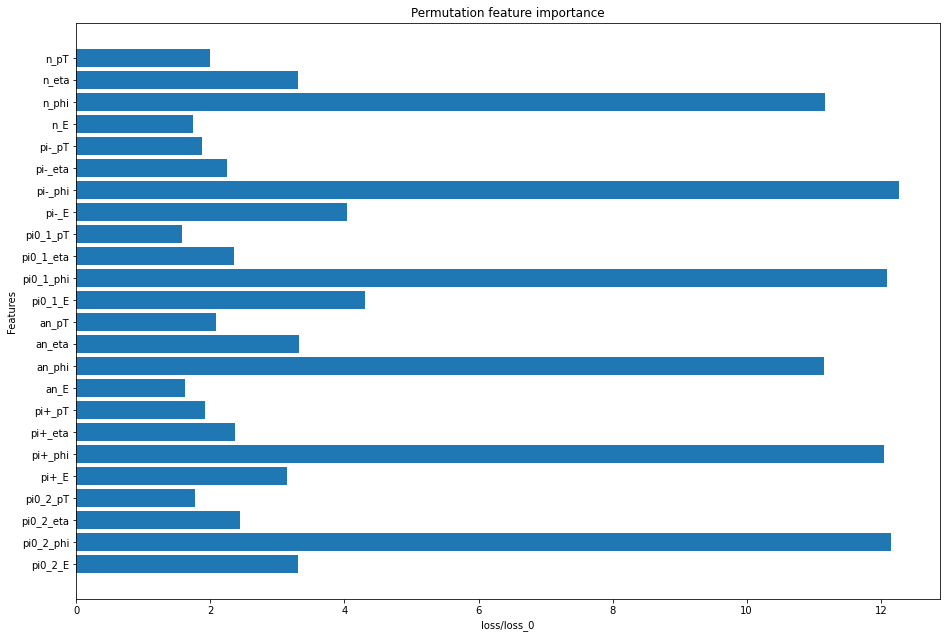

In [28]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0,0,1,1])
features = features_names
loss = np.concatenate(feat_imp.to_numpy())
ax.barh(features,loss)
ax.set_xlabel('loss/loss_0')
ax.set_ylabel('Features')
ax.set_title('Permutation feature importance')
plt.gca().invert_yaxis()
plt.show()